In [1]:
'''!!!!!!!!!!!!!!!!!DO NOT RUN THIS NOTEBOOK ON YOUR COMPUTER...RUN IT IN GOOGLE COLAB!!!!!!!!!!!!!!!
for the fastest performance change the notebook runtime to GPU
'''
#install pyspellchecker
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 12.3MB/s 


In [2]:
#import libraries
import torch.nn as nn
import torch
import pandas as pd
from gensim import models
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from spellchecker import SpellChecker

In [3]:
#load dataset
augmented_data = pd.read_csv('./drive/My Drive/Augmented_Data2.csv')

(array([797.,   0., 649.,   0.,   0., 440.,   0., 568.,   0., 735.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

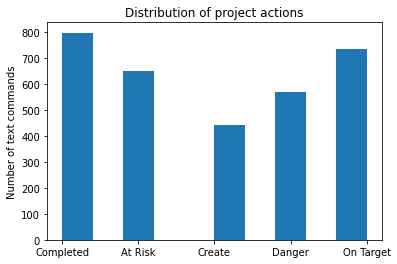

In [26]:
#distribution of labels for use case. Change Project to Tasks in the first line to plot distribution of task labels instead 
data = augmented_data[augmented_data['Topic'] == 'Project']
plt.title('Distribution of project actions')
plt.ylabel('Number of text commands')
plt.hist(data['Action'])

In [ ]:
#code for calculating the average length of text commands in the dataset and then extrapolating 
#to find the number of seconds it would take an average user to type an average length text command
lengths = []
for i in augmented_data.index.values:
  text_command = augmented_data.loc[i][0].split()
  lengths.append(len(text_command))
avg_num_words = sum(lengths)/len(lengths)
avg_wpm = 41
avg_wps = avg_wpm/60
avg_time = avg_num_words/avg_wps
print(avg_time)

12.116628631539216


In [ ]:
#load Google Word2Vec...DO NOT RUN THIS CELL ON YOUR LOCAL COMPUTER
w = models.KeyedVectors.load_word2vec_format('./drive/My Drive/google-word2vec.bin', binary=True)

In [ ]:
#words that will not be vectorized
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]  

In [ ]:
#function for cleaning sentence by removing grammmar 
def clean_sentence(sentence):
  cleaned_sentence = ''
  for char in sentence:
    if char.isalpha() or char == ' ':
      cleaned_sentence += char
    if char == '-':
      cleaned_sentence += ' '
  return cleaned_sentence

In [ ]:
#function for transforming sentence into 2D numerical array 
def vectorize_sentence(sentence,vectorizer,max_len):
  #load spell checker
  spell_checker = SpellChecker()
  #return cleaned sentence
  cleaned_sentence = clean_sentence(sentence)
  #separate cleaned sentence into words
  sentence_lst = cleaned_sentence.split()
  num_words = len(sentence_lst)
  #placeholder for the 2D array that represents the text command which will be inputted into models
  #every text command needs to have the same number of rows for model training purposes 
  sentence_vector = np.zeros((max_len,300))
  #iterate over words in text command
  for i in range(num_words):
    word = sentence_lst[i]
    #only vectorize words that are not stopwords
    if word not in stopwords:
      #check if the vectorizer has been trained on the word
      try:
        vectorized_word = vectorizer.wv[word]
      #if not check if the spell checker can recognize the word and change it into the correct word
      except:
        misspelled = spell_checker.unknown([word])
        corrected_word = None
        for word in misspelled:
          corrected_word = spell_checker.correction(word)
        #check if the spell checker was able to fix the word
        try:
          vectorized_word = vectorizer.wv[corrected_word]
        #if not then represent the word with an empty array of 0s
        except:
          vectorized_word = np.zeros(300)
    else:
      #if the word is a stop word then represent it with an empty array of 0s
      vectorized_word = np.zeros(300)
    #replace the corresponding index in the text command array with the word array
    sentence_vector[i] = vectorized_word
  #if the number of words in the text command is shorter than the number of rows in the array,
  #the remaining missing space will be empty arrays of 0s
  return sentence_vector

In [ ]:
print(torch.tensor(vectorize_sentence('Done with project data cleaning',w,10)))

tensor([[ 0.0654,  0.2305, -0.2891,  ..., -0.2715, -0.0043,  0.1611],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0181,  0.0085,  0.0698,  ..., -0.1250, -0.0562, -0.1084],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


In [ ]:
#function for changing pandas dataframe from sentences to 2D numerical array
def vectorize_dataset(df, column, filter=None):
  #shuffle dataset around to ensure randomness 
  df = df.sample(frac=1).reset_index(drop=True)
  #if the filter parameter is specified then extract either the task action or project action text commands
  if filter != None:
    df = df.loc[df['Topic'] == filter]
  text_commands = df['Text Command']
  num_rows = len(df.index)
  #maximum length of text commands 
  max_len = max([len(text_commands.loc[i].split()) for i in df.index.values])
  #3D numerical array of shape (n,max_len,d) where n is the number of text commands, max_len is the maximum length of text commands
  #, and d is the feature dimension of the word vector which is 300 for Google Word2Vec
  data_vector = np.zeros((num_rows,max_len,300))
  idx = 0
  #iterate through text commands
  for i in df.index.values:
    sentence = df.loc[i][0]
    #transform text command into vectorized format 
    vectorized_sentence = vectorize_sentence(sentence,w,max_len) 
    data_vector[idx] = vectorized_sentence
    idx += 1
  return data_vector, df[column], max_len, text_commands

In [ ]:
#load all the data and labels associated with the different use cases
topic_data, topic_labels, topic_max_len, topic_text_commands = vectorize_dataset(augmented_data, 'One Hot Encoded Topic')
task_action_data, task_action_labels, task_action_max_len, task_action_text_commands = vectorize_dataset(augmented_data, 'One Hot Encoded Action', 'Task')
project_action_data, project_action_labels, project_action_max_len, project_action_text_commands = vectorize_dataset(augmented_data, 'One Hot Encoded Action', 'Project')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
#function for converting the data represented by numpy arrays into tensors
def data_to_tensor(labels,data,array_size):
  labels_tensor = np.zeros((len(labels.index),array_size))
  idx = 0
  for i in (labels.index.values):
    labels_tensor[idx] = np.fromstring(labels.loc[i][1:-1], dtype=np.float64, sep=',') 
    idx += 1
  data_tensor = torch.tensor(data)
  labels_tensor = torch.tensor(labels_tensor)
  return labels_tensor, data_tensor

In [ ]:
#convert all the data into tensor format 
topic_labels, topic_data = data_to_tensor(topic_labels,topic_data,2)
task_action_labels, task_action_data = data_to_tensor(task_action_labels,task_action_data,5)
project_action_labels, project_action_data = data_to_tensor(project_action_labels, project_action_data,5)



In [ ]:
#loading the data can take some time so you can just load the data from saved PyTorch files
topic_labels = torch.load('./drive/My Drive/tensors/topic_labels.pt')
topic_data = torch.load('./drive/My Drive/tensors/topic_data.pt')
task_action_labels = torch.load('./drive/My Drive/tensors/task_action_labels.pt')
task_action_data = torch.load('./drive/My Drive/tensors/task_action_data.pt')
project_action_labels = torch.load('./drive/My Drive/tensors/project_action_labels.pt')
project_action_data = torch.load('./drive/My Drive/tensors/project_action_data.pt')

In [ ]:
#LSTM architecture that takes input of vectorized sentences and outputs probability for each topic
class TopicModel(nn.Module):
  def __init__(self):
    super(TopicModel,self).__init__()
    #feature dimension of input data is 300, there are 100 hidden nodes in LSTM unit layers, and the model will be trained in batch format
    self.lstm = nn.LSTM(300,100,batch_first = True)
    """Change the second parameter according to whether topic or project and task are being trained. 2 is for topic, 5 is for project/task"""
    #fully connected layer that connects the 100 dimension last hidden state to the number of possible labels 
    self.outputtopic = nn.Linear(100,5)
    #Logsoftmax layer that converts outputs into log probabilities 
    self.softmax = nn.LogSoftmax(dim=-1)

  #function for forward pass of model using batch input 
  def forward(self,x):
    #output is the values for every hidden state in the LSTM. h_n and c_n are the hidden state and cell state from the last unit in the LSTM
    output, (h_n,c_n) = self.lstm(x)
    #send the last hidden state through the fully connected linear layer 
    outputt = self.outputtopic(h_n)
    #send the outputs through Logsoftmax layer 
    prob_output = self.softmax(outputt)
    return prob_output



In [ ]:
#set feature size of hidden units
hidden_size = 100

#feature dimension of Google Word2Vec word vector(default is 300)
input_size = 300
"""Change this number according to whether topic or project and task are being trained. 2 is for topic, 5 is for project/task"""
#number of topics to predict
num_topics = 5

#set learning rate 
lr = .1

#set training loss metric
loss_metric = nn.NLLLoss()

In [ ]:
#rename data for training purposes 
topic_text_commands,topic_text_commands_raw_text = topic_data, topic_text_commands
project_action_text_commands,project_action_text_commands_raw_text = project_action_data, project_action_text_commands
task_action_text_commands,task_action_text_commands_raw_text = task_action_data, task_action_text_commands


In [ ]:
def train(topic_tensor, text_command_tensor):
    #indicate that model will be training 
    model.train()
    #reset the model gradients to 0
    model.zero_grad()
    #predicted label from model
    output = model(text_command_tensor.float())[0]
    idxs = torch.argmax(topic_tensor,dim=-1)
    #calculate negative log likelihood loss from batch of data 
    loss = loss_metric(output, idxs)
    #backpropogate through the model based on NLL loss
    loss.backward()
    #update model parameters using gradients 
    optimizer.step()
    

    return output, loss.item()

In [ ]:
#function for testing model on batch of data
def test(model, topic_tensor, text_command_tensor):
  #indicate that model is not training 
  model.eval()
  #calculate NLL loss without reducing meaning return loss for every text command 
  loss_metric = nn.NLLLoss(reduction='none')
  num_labels = len(topic_tensor[0])
  #model predictions on testing text commands
  preds = model(text_command_tensor.float())[0]
  #indexes of max log probability for each prediction 
  idxs = torch.argmax(topic_tensor[0],dim=-1)
  #compute NLL loss for entire testing text commands using the correct indexes and predictions 
  loss = loss_metric(preds, idxs)
  """Change these values to either 2 or 5 zeros based on what labels the model is training on """
  #NLL losses for individual labels
  label_losses = torch.zeros(5)
  label_counts = torch.zeros(5)
  correct = 0
  #iterate over the labels in the dataset
  for i in range(num_labels):
    label = topic_tensor[0][i]
    label_idx = torch.argmax(label)
    #update the count of the specific label
    label_counts[label_idx] += 1
    #NLL loss for the all labels set to 0
    label_loss = torch.zeros(5)
    #set the NLL loss for the specific label
    label_loss[label_idx] = loss[i]
    #update the NLL losses for all labels using the specific label loss 
    label_losses += label_loss
    pred = preds[i]
    pred_idx = torch.argmax(pred)
    #if predicted label equals ground truth label then increment count of correct labels
    if pred_idx == label_idx:
      correct += 1
  return ((correct/num_labels), label_losses/label_counts)



In [ ]:
#function for making prediction on input text command 
def predict(model, text_input, wordvec,label2pred):
  model.eval()
  vectorized_sentence = vectorize_sentence(text_input,wordvec,10)
  sentence_tensor = torch.tensor(vectorized_sentence)
  batch_sentence_tensor = torch.unsqueeze(sentence_tensor,0)
  #returns array of log probabilities assigned to each label 
  pred = model(batch_sentence_tensor.float())
  #return label2pred[int(torch.argmax(pred,dim=-1))]
  return pred


In [ ]:
#function for calculating the optimal confidence threshold that determines whether model should return prediction or not 
def optimize(model, topic_tensor, text_command_tensor,prob_thresh,weights):
  model.eval()
  num_labels = len(topic_tensor[0])
  preds = model(text_command_tensor.float())[0]
  idxs = torch.argmax(topic_tensor[0],dim=-1)
  loss = loss_metric(preds, idxs)
  #based on inputted weights, check out many correct, incorrect, and non predictions are made
  correct = 0
  incorrect = 0
  NA = 0
  #log probability based on inputted probability threshold 
  log_prob_thresh = np.log(prob_thresh)
  #iterate over predictions 
  for i in range(num_labels):
    pred = preds[i]
    pred_idx = torch.argmax(pred)
    #find the maximum log probability assigned to the labels 
    pred_log_prob = torch.max(pred)
    label = topic_tensor[0][i]
    label_idx = torch.argmax(label)
    #if the maximum log probability is greater than or equal to the log probability threshold 
    if pred_log_prob >= log_prob_thresh:
      #if prediction is correct then update count
      if pred_idx == label_idx:
        correct += 1
      #if prediction is wrong then update count
      else:
        incorrect += 1
    #if the log probability is less than, update count 
    else:
      NA += 1
  #calculate the total number of time that would be saved if a user typed every text command from the inputted dataset
  #given that the model is using the inputted confidence threshold. The inputted weights represent how much time is 
  #saved through a correct prediction, how much time is lost through a non prediction, and how much time is lost through an incorrect prediction 
  time_saved = correct*weights[0]-incorrect*weights[1]-NA*weights[2]
  return time_saved

In [ ]:
#if the runtime type is set to GPU, PyTorch will use cuda which is faster 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#number of training iterations
epochs = 100
#set batch size 
batch_size = 40

# Keep track of losses for plotting
testing_losses = []
testing_accuracies = []
testing_losses = torch.zeros(2)
#number of times to train and test the model
for i in range(20):
  print(i)
  current_loss = 0
  all_losses = []
  model = TopicModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr)
  #shuffle around dataset 
  idxs = torch.randperm(len(topic_text_commands))
  text_commands = topic_text_commands[idxs]
  labels = topic_labels[idxs]
  #split the training and testing text commands using an 80/20 split 
  training_text_commands,testing_text_commands = text_commands[:5520], text_commands[5520:6900]
  training_labels, testing_labels = labels[:5520], labels[5520:6900]

  #set number of batches
  training_num_batches = int(len(training_text_commands)/batch_size) 

  #reshape text commands and labels to fit training
  training_text_commands = torch.reshape(training_text_commands,(training_num_batches,batch_size,topic_max_len,300))
  training_labels = torch.reshape(training_labels,(training_num_batches,batch_size,num_topics))
  testing_labels = torch.reshape(testing_labels,(1,testing_labels.shape[0],testing_labels.shape[1]))
  training_losses = []
  #iterate over training iterations 
  for iter in range(1, epochs + 1):
    #training using mini batch gradient descent so we iterate over the text command batches 
    for batch_iter in range(training_num_batches):
      text_batch, label_batch = training_text_commands[batch_iter], training_labels[batch_iter]
      #train and update the model using the current batch 
      output, loss = train(label_batch, text_batch)
      #add batch loss to running sum of training loss 
      current_loss += loss
    #add average training loss across all batches to list 
    training_losses.append(current_loss/training_num_batches)

    #once the model has finished training for the current iteration 
    if iter == epochs:
      #calculate testing accuracy and testing loss per label for testing dataset 
      testing_accuracy, testing_loss = test(model, testing_labels, testing_text_commands)
      testing_accuracies.append(testing_accuracy)
      testing_losses += testing_loss
    #reset the training loss for the next training epoch
    current_loss = 0
  #list that will contain all the times saved from different probability thresholds 
  times_saved = []
  #iterate over every probability threshold 
  for i in range(100):
    percent = i/100
    #time that user would save given inputted weights and probability threshold 
    time_saved = optimize(model,testing_labels,testing_text_commands,percent,[2,12,5])
    times_saved.append(time_saved)


In [ ]:
#average loss for each label in testing dataset 
testing_losses/len(testing_accuracies)

tensor([0.1512, 0.1355], grad_fn=<DivBackward0>)

In [ ]:
#average testing accuracy across iterations 
sum(testing_accuracies)/len(testing_accuracies)

0.9635869565217392

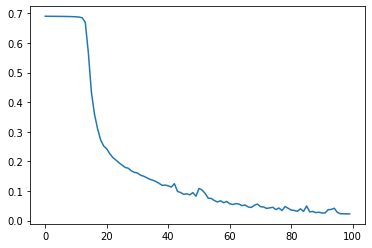

In [ ]:
plt.plot(training_losses)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Training project action
epochs = 150
#set batch size 
batch_size = 40

# Keep track of losses for plotting
testing_losses = []
testing_accuracies = []
testing_losses = torch.zeros(5)
for i in range(1):
  print(i)
  current_loss = 0
  all_losses = []
  model = TopicModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr)

  idxs = torch.randperm(len(project_action_text_commands))
  text_commands = project_action_text_commands[idxs]
  labels = project_action_labels[idxs]

  training_text_commands,testing_text_commands = text_commands[:2480], text_commands[2480:3100]
  training_labels, testing_labels = labels[:2480], labels[2480:3100]

  #set number of batches
  training_num_batches = int(len(training_text_commands)/batch_size) 

  #reshape text commands and labels to fit training
  training_text_commands = torch.reshape(training_text_commands,(training_num_batches,batch_size,project_action_max_len,300))
  training_labels = torch.reshape(training_labels,(training_num_batches,batch_size,num_topics))
  testing_labels = torch.reshape(testing_labels,(1,testing_labels.shape[0],testing_labels.shape[1]))
  training_losses = []
  for iter in range(1, epochs + 1):
    for batch_iter in range(training_num_batches):
      text_batch, label_batch = training_text_commands[batch_iter], training_labels[batch_iter]
      output, loss = train(label_batch, text_batch)
      current_loss += loss
    # Add current loss avg to list of losses
    training_losses.append(current_loss/training_num_batches)
    if iter == epochs:
      testing_accuracy, testing_loss = test(model, testing_labels, testing_text_commands)
      testing_accuracies.append(testing_accuracy)
      testing_losses += testing_loss
      all_losses.append(current_loss / training_num_batches)
    current_loss = 0
times_saved = []
for i in range(100):
  percent = i/100
  time_saved = optimize(model,testing_labels,testing_text_commands,percent,[4,28,12])
  times_saved.append(time_saved)

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
testing_losses/len(testing_accuracies)

tensor([0.5496, 0.0655, 0.1562, 0.8179, 0.1993], grad_fn=<DivBackward0>)

In [ ]:
sum(testing_accuracies)/len(testing_accuracies)

0.9112903225806451

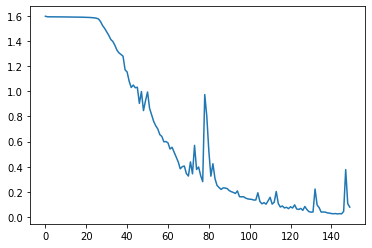

In [ ]:
plt.plot(training_losses)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Training task action
epochs = 205
#set batch size 
batch_size = 40

# Keep track of losses for plotting
testing_losses = []
testing_accuracies = []
testing_losses = torch.zeros(5)
for i in range(1):
  print(i)
  current_loss = 0
  all_losses = []
  model = TopicModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr)

  idxs = torch.randperm(len(task_action_text_commands))
  text_commands = task_action_text_commands[idxs]
  labels = task_action_labels[idxs]

  training_text_commands,testing_text_commands = text_commands[:2960], text_commands[2960:3700]
  training_labels, testing_labels = labels[:2960], labels[2960:3700]

  #set number of batches
  training_num_batches = int(len(training_text_commands)/batch_size) 

  #reshape text commands and labels to fit training
  training_text_commands = torch.reshape(training_text_commands,(training_num_batches,batch_size,task_action_max_len,300))
  training_labels = torch.reshape(training_labels,(training_num_batches,batch_size,num_topics))
  testing_labels = torch.reshape(testing_labels,(1,testing_labels.shape[0],testing_labels.shape[1]))
  training_losses = []
  for iter in range(1, epochs + 1):
    for batch_iter in range(training_num_batches):
      text_batch, label_batch = training_text_commands[batch_iter], training_labels[batch_iter]
      output, loss = train(label_batch, text_batch)
      current_loss += loss

    training_losses.append(current_loss/training_num_batches)

    # Add current loss avg to list of losses
    if iter == epochs:
      testing_accuracy, testing_loss = test(model, testing_labels, testing_text_commands)
      testing_accuracies.append(testing_accuracy)
      testing_losses += testing_loss
      all_losses.append(current_loss / training_num_batches)
    
    current_loss = 0
times_saved = []
for i in range(100):
  percent = i/100
  time_saved = optimize(model,testing_labels,testing_text_commands,percent,[4,28,12])
  times_saved.append(time_saved)

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
sum(testing_accuracies)/len(testing_accuracies)

0.9081081081081082

In [ ]:
testing_losses/len(testing_accuracies)

tensor([1.1072, 0.2269, 0.4038, 0.4443, 0.2795], grad_fn=<DivBackward0>)